In [12]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm

In [25]:
warnings.filterwarnings('ignore')

In [15]:
def event_region(lat_event,lon_event,lon_w,lon_e):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event <= lon_e))[0]
    return idx

In [16]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [17]:
# MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
# Gridsat_dir = '/w2-data/willytsai/gridsat_BT/remap_0.25deg/'
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
# MERRA2_3d_dir = '/w2-data/willytsai/TQUV_3hr/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.1deg/'
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
MERRA2_3d_dir = '/data/willytsai/TQUV_3hr/'
MERRA2_TQCI_dir = '/data/willytsai/TQCI_3hr'
AIRS_dir = '/data/willytsai/AIRS_daily'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
WHOI_dir = '/data/willytsai/WHOI_oaflux/'

In [18]:
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [19]:
# precipitation events over specific basins: 
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]
idx_REG = event_region(lat_event,lon_event,-180,180) # all tropics

# total event over IND
time_event = np.asarray(time_event); time_event = time_event[idx_REG]
lat_event = var_dataset[idx_REG,0]
lon_event = var_dataset[idx_REG,1]

In [22]:
t_org = np.where(lat_event>-50)[0]
len(t_org)

108419

In [23]:
### test starts 
t=0

### MSE tedency provided: PHY, DYN and ANA

In [58]:
data_sub7 = subset_MERRA2(MERRA2_dir+'/tavg_2d_ANA'
                    ,time_event[t],lat_event[t],lon_event[t],days=2,
                    lat_inc=2.5,lon_inc=2.5)

dh_ana_sm = data_sub7.DHDT_ANA # MERRA2 analysis tendency of CpT
dq_ana_sm = data_sub7.DQVDT_ANA # MERRA2 analysis tendecny of q  
dh_phy_sm = data_sub7.DHDT_PHY # MERRA2 physics tendency of CpT
dq_phy_sm = data_sub7.DQVDT_PHY # MERRA2 physics tendecny of q      
dh_dyn_sm = data_sub7.DHDT_DYN # MERRA2 dynamics tendency of CpT
dq_dyn_sm = data_sub7.DQVDT_DYN # MERRA2 dynamics tendecny of q  

### MSE tendency derived by equations

In [142]:
# 3-hourly data for 3d vars
data_sub1 = subset_MERRA2(MERRA2_3d_dir
                 ,time_event[t],lat_event[t],lon_event[t],days=2,
                  lat_inc=2.5,lon_inc=2.5)
data_sub2 = subset_MERRA2(MERRA2_3d_dir+'../geoheight_3hr/'
                 ,time_event[t],lat_event[t],lon_event[t],days=2,
                  lat_inc=2.5,lon_inc=2.5)
data_sub3 = subset_MERRA2(MERRA2_3d_dir+'../omega_3hr'
                 ,time_event[t],lat_event[t],lon_event[t],days=2,
                  lat_inc=2.5,lon_inc=2.5)

q_sm = data_sub1.QV
T_sm = data_sub1.T
u_sm = data_sub1.U
v_sm = data_sub1.V
omega_sm = data_sub3.OMEGA
z_sm = data_sub2.H
lev = z_sm.lev
lon = z_sm.lon
lat = z_sm.lat

h_sm = 1004*T_sm + 2.5e6*q_sm + 9.8*z_sm 
dhdx = np.gradient(-u_sm*h_sm,lon*100000,axis=3)
dhdy = np.gradient(-v_sm*h_sm,lat*100000,axis=2)
dhdz = np.gradient(-omega_sm*h_sm,lev*100,axis=1)
MSE_dyn_calc = -1/9.8*np.trapz(dhdx+dhdy+dhdz,lev*100,axis=1)

dqdx = np.gradient(-u_sm*q_sm,lon*100000,axis=3)
dqdy = np.gradient(-v_sm*q_sm,lat*100000,axis=2)
dqdz = np.gradient(-omega_sm*q_sm,lev*100,axis=1)
dq_dyn_calc = -1/9.8*np.trapz(dqdx+dqdy+dqdz,lev*100,axis=1)

dHdx = np.gradient(-u_sm*1004*T_sm,lon*100000,axis=3)
dHdy = np.gradient(-v_sm*1004*T_sm,lat*100000,axis=2)
dHdz = np.gradient(-omega_sm*1004*T_sm,lev*100,axis=1)
dH_dyn_calc = -1/9.8*np.trapz(dHdx+dHdy+dHdz,lev*100,axis=1)

##------- cwv 
cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
              ,time_event[t],lat_event[t],lon_event[t],days=2,
              lat_inc=2.5,lon_inc=2.5)
cwv_sm = cwv_sub.TQV


cwv_cal_sm = -1/9.8*np.trapz(q_sm,lev*100,axis=1)

In [110]:
vint_gz_sm = np.trapz(z_sm,lev*100,axis=1)

In [ ]:
MSE_dyn_sm = dh_dyn_sm+2.5e6*dq_dyn_sm
MSE_phy_sm = dh_phy_sm+2.5e6*dq_phy_sm
MSE_ana_sm = dh_ana_sm+2.5e6*dq_ana_sm

In [61]:
M2_dyn.shape

(33, 11, 9)

Text(0.5, 1.0, 'dq/dt from DYN')

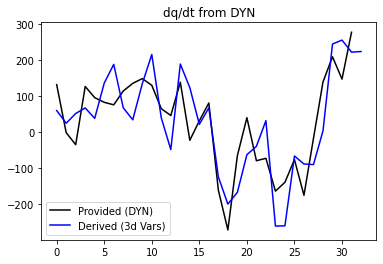

In [152]:
plt.plot(np.nanmean(2.5e6*dq_dyn_sm.resample(time='3H').nearest(),axis=(1,2)),'k')
plt.plot(np.nanmean(2.5e6*dq_dyn_calc,axis=(1,2)),'b')
plt.legend(['Provided (DYN)','Derived (3d Vars)'])
plt.title('dq/dt from DYN')

Text(0.5, 1.0, 'dCpT/dt from DYN')

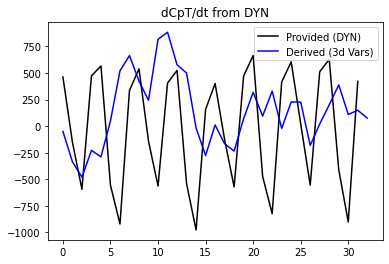

In [153]:
plt.plot(np.nanmean(dh_dyn_sm.resample(time='3H').nearest(),axis=(1,2)),'k')
plt.plot(np.nanmean(dH_dyn_calc,axis=(1,2)),'b')
plt.legend(['Provided (DYN)','Derived (3d Vars)'])
plt.title('dCpT/dt from DYN')

In [105]:
cwv_dt = np.diff(cwv_sm,axis=0) # dq/dt
vint_MSE_dt = np.diff(-1/9.8*np.trapz(h_sm,lev*100,axis=1),axis=0) # dMSE/dt

In [125]:
vint_gz_dt = np.diff(vint_gz_sm,axis=0)/10800 # dgz/dt

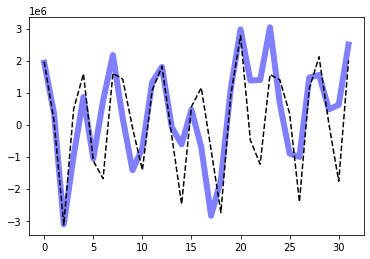

In [127]:
plt.plot(np.nanmean(vint_MSE_dt,axis=(1,2)),'b',linewidth=6,alpha=0.5)
plt.plot(3600*((MSE_dyn_sm + MSE_phy_sm + MSE_ana_sm).resample(time='3H')).nearest().mean(axis=(1,2))+
         3600*vint_gz_dt.mean(axis=(1,2)),'--k')

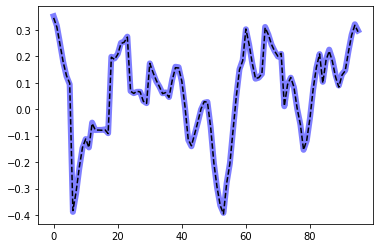

In [86]:
plt.plot(cwv_dt.mean(axis=(1,2)),'b',linewidth=6,alpha=0.5)
plt.plot(3600*(dq_dyn_sm+dq_phy_sm+dq_ana_sm).mean(axis=(1,2)),'--k')

In [90]:
os.chdir('/data/willytsai/ISCCP')
idx_decile = np.load('idx_decile_5deg.npy',allow_pickle=True)